# Conditonal Neural Processes

Toy implementation of conditional neural processes in pytorch.
Based on [DeepMind's implementation](https://github.com/deepmind/neural-processes/blob/master/conditional_neural_process.ipynb).

## Conditional Neural Processes (CNP) for 1D regression.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import collections

### Data Generator

In [0]:
CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))

In [0]:
class GPCurvesReader(object):
    def __init__(self, batch_size, max_num_context, x_size=1, y_size=1, l1_scale=0.4, sigma_scale=1.0, testing=False):
        '''
        Creates a regression dataset of functions samples from a GP.

        @param batch_size: An integer.
        @param max_num_context: The max number of observations in the context.
        @param x_size: Integer >= 1 for length of "x values" vector.
        @param y_size: Integer >= 1 for length of "y values" vector.
        @param l1_scale: Float; typical scale for kernel distance function.
        @param sigma_scale: Float; typical scale for variance.
        @param testing: Boolean that indicates whether we are testing. If so there are
            more targets for visualization.
        '''
        self.batch_size = batch_size
        self.max_num_context = max_num_context
        self.x_size = x_size
        self.y_size = y_size
        self.l1_scale = l1_scale
        self.sigma_scale = sigma_scale
        self.testing = testing

    def gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        '''
        Applies the Gaussian kernel to generate curve data

        @param xdata: tensor with shape `[batch_size, num_total_points, x_size]` with
            the values of the x-axis data.
        @param l1: tensor with shpae `[batch_size, y_size, x_size]`, the scale parameter of the
            Gaussian kernel.
        @param sigma_f: float tensor with shpae `[batch_size, y_size]`, the magnitude of the std.
        @param sigma_noise: float, std of the noise we add for stability
        @return kernel: float tensor with shape `[batch_size, y_size, num_total_points, num_total_points]`.
        '''
        num_total_points = xdata.size(1)

        # Expand and take the difference
        xdata1 = xdata.unsqueeze(1)
        xdata2 = xdata.unsqueeze(2)
        diff = xdata1 - xdata2

        norm = (diff[:,None,:,:,:] / l1[:,:,None,None,:]) ** 2

        norm = torch.sum(norm, dim=-1)

        kernel = ((sigma_f) ** 2)[:,:,None,None] * torch.exp(-0.5 * norm)

        kernel += (sigma_noise ** 2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        '''
        Builds the op delivering the data.
        Generated functions are `float32` with x values between -2 and 2.

        @return A `CNPRegressionDescription` namedtuple.
        '''
        num_context = torch.randint(low=3, high=self.max_num_context+1, size=(1,)).item()

        if self.testing:
            num_target = 400
            num_total_points = num_target
            #x_values = torch.arange(-2., 2., 1. / 100, dtype=torch.float32).unsqueeze(0).repeat(1, self.batch_size, 1)
            x_values = torch.arange(-2., 2., 1. / 100, dtype=torch.float32).unsqueeze(0).repeat(self.batch_size, 1)
            x_values = x_values.unsqueeze(-1)
        else:
            num_target = torch.randint(low=2, high=self.max_num_context+1, size=(1, )).item()
            num_total_points = num_context + num_target
            # generate x_values between -2 and 2
            x_values = torch.rand((self.batch_size, num_total_points, self.x_size))
            x_values = 4 * x_values - 2

        l1 = torch.ones(self.batch_size, self.y_size, self.x_size) * self.l1_scale
        
        sigma_f = torch.ones(self.batch_size, self.y_size) * self.sigma_scale

        kernel = self.gaussian_kernel(x_values, l1, sigma_f)

        cholesky = torch.cholesky(kernel.type(torch.DoubleTensor)).type(torch.FloatTensor)

        y_values = torch.matmul(cholesky, torch.randn(self.batch_size, self.y_size, num_total_points, 1))

        y_values = y_values.squeeze(3).permute(0, 2, 1)

        if self.testing:
            target_x = x_values
            target_y = y_values

            #idx = torch.from_numpy(np.random.permutation(np.arange(num_target)))
            idx = torch.randperm(num_target)
            context_x = torch.gather(x_values, 1, idx[None,:num_context,None]) # fix it
            context_y = torch.gather(y_values, 1, idx[None,:num_context,None]) # fit it
        else:
            target_x = x_values[:,:num_target + num_context, :]
            target_y = y_values[:,:num_target + num_context, :]

            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return CNPRegressionDescription(query=query, target_y=target_y, num_total_points=target_x.size(1), num_context_points=num_context)


In [0]:
TRAINING_ITERATIONS = int(2e5)
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = int(2e4)

In [0]:
# Train dataset
dataset_train = GPCurvesReader(
    batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
data_train = dataset_train.generate_curves()

# Test dataset # TODO: fix test
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()


### Encoder

In [0]:
class DeterministicEncoder(nn.Module):
    def __init__(self, output_sizes):
        '''
        CNP encoder

        @param output_sizes: An iterable containing the output sizes of the encoding MLP.
        '''
        super(DeterministicEncoder, self).__init__()
        encoder = [nn.Linear(2, output_sizes[0]), nn.ReLU(inplace=True)]
        for i in range(1,len(output_sizes)):
            encoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                encoder += [nn.ReLU(inplace=True)]

        self.encoder = nn.Sequential(*encoder)


    def forward(self, context_x, context_y):
        '''
        Encodes the inputs into one representation.

        @param context_x: Tensor of size bs x observations x m_ch. For this 1D regression
            task this corresponds to the x-values.
        @param context_y: Tensor of size bs x observations x d_ch. For this 1D regression
            task this corresponds to the y-values.
        @param num_context_points: A tensor containing a single scalar that indicates the
            number of context_points provided in this iteration.
        @return representation: The encoded representation averaged over all context 
            points.
        '''
        encoder_input = torch.cat([context_x, context_y], dim=-1)
        batch_size, num_context_points, _ = encoder_input.shape
        encoder_input = encoder_input.view(batch_size * num_context_points, -1)

        representation = self.encoder(encoder_input).view(batch_size, num_context_points, -1)
        return torch.mean(representation, dim=1)

### Decoder

In [0]:
class DeterministicDecoder(nn.Module):
    def __init__(self, output_sizes):
        '''
        CNP decoder

        @param output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `nn.Linear`.
        '''
        super(DeterministicDecoder, self).__init__()
        decoder = [nn.Linear(129, output_sizes[0]), nn.ReLU(inplace=True)]
        for i in range(1, len(output_sizes)):
            decoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                decoder += [nn.ReLU(inplace=True)]

        self.decoder = nn.Sequential(*decoder)


    def forward(self, representation, target_x, num_total_points):
        '''
        Decodes the individual targets.

        @param representation: The encoded representation of the context
        @param target_x: The x locations for the target query
        @param num_total_points: The number of target points.
        @return dist: A multivariate Gaussian over the target points.
        @return mu: The mean of the multivariate Gaussian.
        @return sigma: The standard deviation of the multivariate Gaussian.
        '''
        representation = representation.unsqueeze(1).repeat(1, num_total_points, 1)
        decoder_input = torch.cat([representation, target_x], dim=-1)
        batch_size, _, _ = decoder_input.shape
        decoder_input = decoder_input.view(batch_size * num_total_points, -1)

        output = self.decoder(decoder_input).view(batch_size, num_total_points, -1)

        # get the mean and variance
        mu, log_sigma = torch.chunk(output, 2, dim=-1)

        # bound the variance
        sigma = 0.1 + 0.9 * F.softplus(log_sigma)

        # get the distribution
        dist = torch.distributions.multivariate_normal.MultivariateNormal(mu, covariance_matrix=torch.diag_embed(sigma))

        return dist, mu, sigma

### Model

In [0]:
class DeterministicModel(nn.Module):
    """The CNP model."""
    def __init__(self, encoder_output_sizes, decoder_output_sizes):
        """
        Initialises the model.

        encoder_output_sizes: An iterable containing the sizes of hidden layers of
            the encoder. The last one is the size of the representation r.
        decoder_output_sizes: An iterable containing the sizes of hidden layers of
            the decoder. The last element should correspond to the dimension of
            the y * 2 (it encodes both mean and variance concatenated)
        """
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_output_sizes)
        self._decoder = DeterministicDecoder(decoder_output_sizes)

    def forward(self, query, num_total_points, num_contexts, target_y=None):
        """
        Returns the predicted mean and variance at the target points.

        query: Array containing ((context_x, context_y), target_x) where:
            context_x: Array of shape batch_size x num_context x 1 contains the 
                x values of the context points.
            context_y: Array of shape batch_size x num_context x 1 contains the 
                y values of the context points.
            target_x: Array of shape batch_size x num_target x 1 contains the
                x values of the target points.
        target_y: The ground truth y values of the target y. An array of 
            shape batchsize x num_targets x 1.
        num_total_points: Number of target points.

        log_p: The log_probability of the target_y given the predicted
        distribution.
        mu: The mean of the predicted distribution.
        sigma: The variance of the predicted distribution.
        """

        (context_x, context_y), target_x = query

        # Pass query through the encoder and the decoder
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x, num_total_points)

        # If we want to calculate the log_prob for training we will make use of the
        # target_y. At test time the target_y is not available so we return None
        if target_y is not None:
            log_p = dist.log_prob(target_y)
        else:
            log_p = None

        return log_p, mu, sigma

### Plot function

In [0]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
    """Plots the predicted mean and variance and the context points.
    
    Args: 
        target_x: An array of shape batchsize x number_targets x 1 that contains the
            x values of the target points.
        target_y: An array of shape batchsize x number_targets x 1 that contains the
            y values of the target points.
        context_x: An array of shape batchsize x number_context x 1 that contains 
            the x values of the context points.
        context_y: An array of shape batchsize x number_context x 1 that contains 
            the y values of the context points.
        pred_y: An array of shape batchsize x number_targets x 1  that contains the
            predicted means of the y values at the target points in target_x.
        pred_y: An array of shape batchsize x number_targets x 1  that contains the
            predicted variance of the y values at the target points in target_x.
    """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - var[0, :, 0],
        pred_y[0, :, 0] + var[0, :, 0],
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.show()

### Running Conditional Neural Processes

In [0]:
TRAINING_ITERATIONS = int(2e4)
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = int(2e3)

In [0]:
# Train dataset
dataset_train = GPCurvesReader(
    batch_size=64, max_num_context=MAX_CONTEXT_POINTS)

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)

In [0]:
# Sizes of the layers of the MLPs for the encoder and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
encoder_output_sizes = [128, 128, 128, 128]
decoder_output_sizes = [128, 128, 2]

# Define the model
model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)

Iteration: 0, loss: 1.4911341667175293


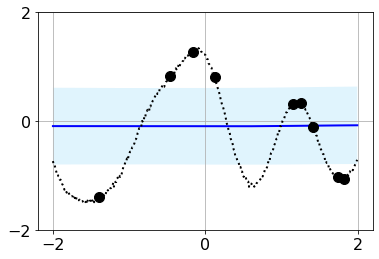

Iteration: 2000, loss: 1.0831166505813599


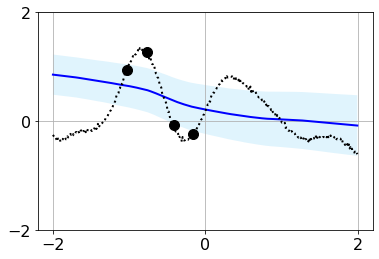

Iteration: 4000, loss: 0.9014894962310791


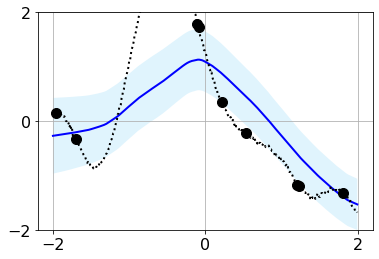

Iteration: 6000, loss: 0.9743045568466187


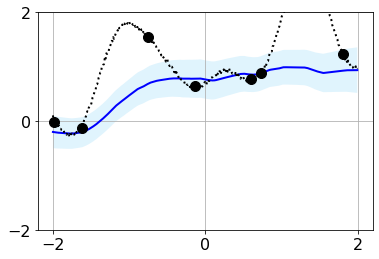

Iteration: 8000, loss: 1.0665749311447144


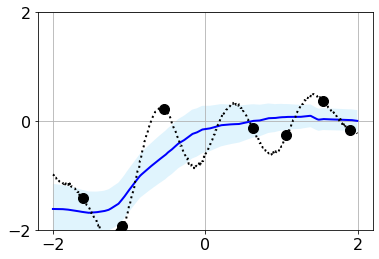

Iteration: 10000, loss: 0.809267520904541


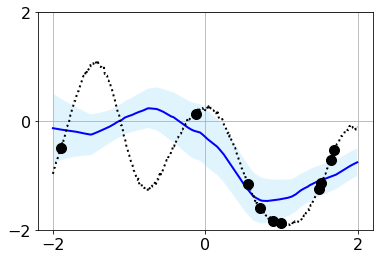

Iteration: 12000, loss: 0.9043251872062683


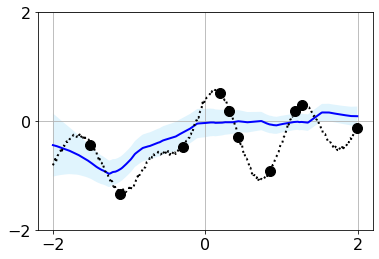

Iteration: 14000, loss: 0.7084773778915405


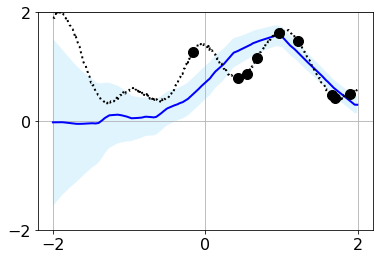

Iteration: 16000, loss: 0.6446948051452637


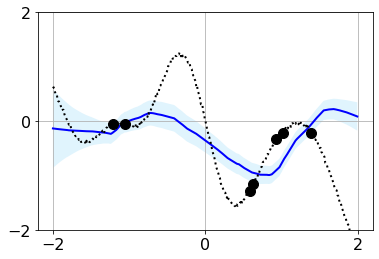

Iteration: 18000, loss: 0.6424611806869507


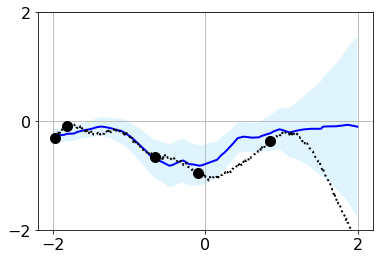

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for it in range(TRAINING_ITERATIONS):
  data_train = dataset_train.generate_curves()
  data_test = dataset_test.generate_curves()
  optimizer.zero_grad()

  log_prob, _, _ = model(data_train.query, data_train.num_total_points,
                          data_train.num_context_points, target_y=data_train.target_y)
  _, mu, sigma = model(data_test.query, data_test.num_total_points,
                          data_test.num_context_points)

  loss = -log_prob.mean()
  loss.backward()
  optimizer.step()

  # Plot the predictions in `PLOT_AFTER` intervals
  if it % PLOT_AFTER == 0:

    (context_x, context_y), target_x = data_test.query
    print('Iteration: {}, loss: {}'.format(it, loss))

    # Plot the prediction and the context
    plot_functions(target_x.detach().numpy(), data_test.target_y.detach().numpy(), context_x.detach().numpy(), 
                   context_y.detach().numpy(), mu.detach().numpy(), sigma.detach().numpy())